# Библитотеки

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from tqdm.notebook import tqdm
import numpy as np
import torch
from torchvision import datasets, transforms
from sklearn import metrics

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = (20.0, 10.0)
rcParams['legend.fontsize'] = 20
rcParams['axes.titlesize']=20
rcParams['axes.labelsize']=20
rcParams['font.size'] = 20
rcParams['lines.linewidth'] = 3

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Данные

In [ ]:
MNIST_train = datasets.MNIST('./mnist', train=True, download=True, 
                             transform=transforms.ToTensor())
MNIST_test = datasets.MNIST('./mnist', train=False, download=True,
                            transform=transforms.ToTensor())

In [ ]:
FMNIST_train = datasets.FashionMNIST('./fmnist', train=True, download=True, 
                             transform=transforms.ToTensor())

FMNIST_test = datasets.FashionMNIST('./fmnist', train=False, download=True,
                            transform=transforms.ToTensor())

In [ ]:
train_big, train_small = torch.utils.data.random_split(FMNIST_train, [59000, 1000], generator=torch.Generator().manual_seed(42))

In [ ]:
mnist_indices = []
for target in range(10):
    ind = []
    for i in range(len(MNIST_train)):
        if (MNIST_train[i][1] == target):
            ind.append(i)
    mnist_indices.append(ind)

In [ ]:
def f_to_d(targets):
    res = []
    for target in targets:
        ind = np.random.choice(mnist_indices[target])
        res.append(MNIST_train[ind][0])
    tensor_res = torch.cat(res).view([len(res), 28, 28])
    return tensor_res.view([-1, 28,28 ]).to(device)

In [ ]:
X = FMNIST_train.data/255
Y = f_to_d(FMNIST_train.targets)
FashionDigit = torch.utils.data.TensorDataset(X,Y)

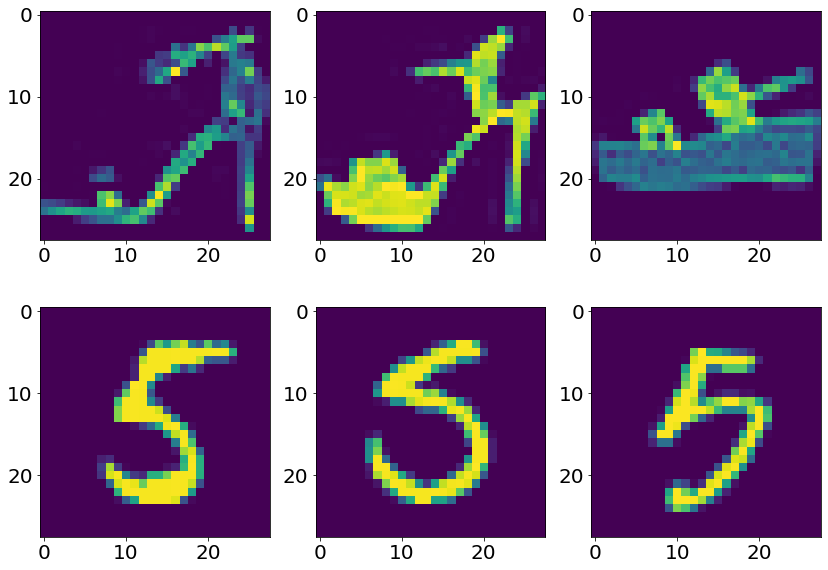

In [ ]:
indices = [8,9,12]

fmnist_images = []
for i in indices:
    fmnist_images.append(FashionDigit[i][0])

mnist_images = []
for i in indices:
    mnist_images.append(FashionDigit[i][1])   

fig, gs = plt.figure(figsize=(14,10)), gridspec.GridSpec(2, 3)

ax = []

for i in range(3):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(fmnist_images[i].view([28,28])))

for i in range(3):
    ax.append(fig.add_subplot(gs[i+3]))
    ax[i+3].imshow(np.array(mnist_images[i].cpu()))

plt.show()

# Модели учителя и ученика

In [ ]:
class Perceptron(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device

    def __init__(self, input_dim=784, num_layers=0, 
                 hidden_dim=64, output_dim=10, p=0.0):
        super(Perceptron, self).__init__()
        
        self.layers = torch.nn.Sequential()
        
        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module('layer{}'.format(i), 
                                  torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module('relu{}'.format(i), torch.nn.ReLU())
            self.layers.add_module('dropout{}'.format(i), torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        
        self.layers.add_module('classifier', 
                               torch.nn.Linear(prev_size, output_dim))        
        
    def forward(self, input):
        return self.layers(input)

In [ ]:
def train_teacher(train_data, test_data, phi=lambda x: x):
    
    teacher = Teacher
    optimizer = torch.optim.Adam(teacher.parameters())
    loss_function = torch.nn.CrossEntropyLoss()

    epochs = 10

    for i in tqdm(range(epochs)):
        train_generator = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
        teacher.train()
        for x, y in tqdm(train_generator, leave=False):
            optimizer.zero_grad()
            #x = x.to(device)
            x = x.view([-1, 784]).to(device)
            y = y.to(device)
            predict = teacher(phi(x))
            loss = loss_function(predict, y)
            loss.backward()
            optimizer.step()

        test_generator = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
        teacher.eval()
        for x, y in tqdm(test_generator, leave=False):
            #x = x.to(device)
            x = x.view([-1, 784]).to(device)
            y = y.to(device)
            predict = teacher(phi(x))
            loss = loss_function(predict, y) 

In [ ]:
def distillation_train(train_data, test_data, teacher=None, T=1, phi=lambda x: x):   
    
    list_of_train_acc = []
    list_of_test_acc = []
    list_of_train_losses = []
    list_of_test_losses = []

    epochs = 20
    attempts = 3
    
    for attempt in tqdm(range(attempts)):
        student = Student
        optimizer = torch.optim.Adam(student.parameters())
        loss_function = torch.nn.CrossEntropyLoss()
        
        train_acc = []
        test_acc = []
        train_losses = []
        test_losses = []
        
        for epoch in tqdm(range(epochs), leave=False):
            train_generator = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
            train_true = 0
            train_loss = 0
            for x, y in tqdm(train_generator, leave=False):
                optimizer.zero_grad()
                x = x.view([-1, 784]).to(device)
                y = y.to(device)
                student_output = student(x)
                
                if (teacher == None):
                    loss = loss_function(student_output, y)
                else:
                    teacher_output = teacher(phi(x))
                    loss = loss_function(student_output, y)\
                    - (torch.softmax(teacher_output/T, axis=1) *\
                       torch.log(torch.softmax(student_output/T, axis=1))).sum(axis=1).mean()

                loss.backward()
                optimizer.step()
                train_true += metrics.accuracy_score(y.cpu(), torch.argmax(student_output, axis=1).cpu())
                train_loss += loss.cpu().item()
                
            test_generator = torch.utils.data.DataLoader(test_data, batch_size=100, shuffle=False)
            test_true = 0
            test_loss = 0
            for x, y in tqdm(test_generator, leave=False):
                x = x.view([-1, 784]).to(device)
                y = y.to(device)
                output = student(x)
                
                loss = loss_function(output, y)
                    
                test_true += metrics.accuracy_score(y.cpu(), torch.argmax(output, axis=1).cpu())
                test_loss += loss.cpu().item()
        
            train_acc.append(train_true*100/len(train_data))
            test_acc.append(test_true*100/len(test_data))
            train_losses.append(train_loss*100/len(train_data))
            test_losses.append(test_loss*100/len(test_data))
            
        list_of_train_acc.append(train_acc)
        list_of_test_acc.append(test_acc)
        list_of_train_losses.append(train_losses)
        list_of_test_losses.append(test_losses)
        
    return list_of_train_acc, list_of_test_acc, list_of_train_losses, list_of_test_losses

In [ ]:
Student = Perceptron(num_layers=1)
Student.to(device)

In [ ]:
_ = Student.train()
list_of_train_acc, list_of_test_acc, list_of_train_losses, list_of_test_losses = distillation_train(train_small, FMNIST_test)

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = Perceptron(num_layers=4).to(device)

In [ ]:
_ = Teacher.train()
train_teacher(train_big, FMNIST_test)

In [ ]:
_ = Student.train()
list_of_train_acc_dist, list_of_test_acc_dist, list_of_train_losses_dist, list_of_test_losses_dist =\
                                distillation_train(train_small, FMNIST_test, teacher=Teacher)

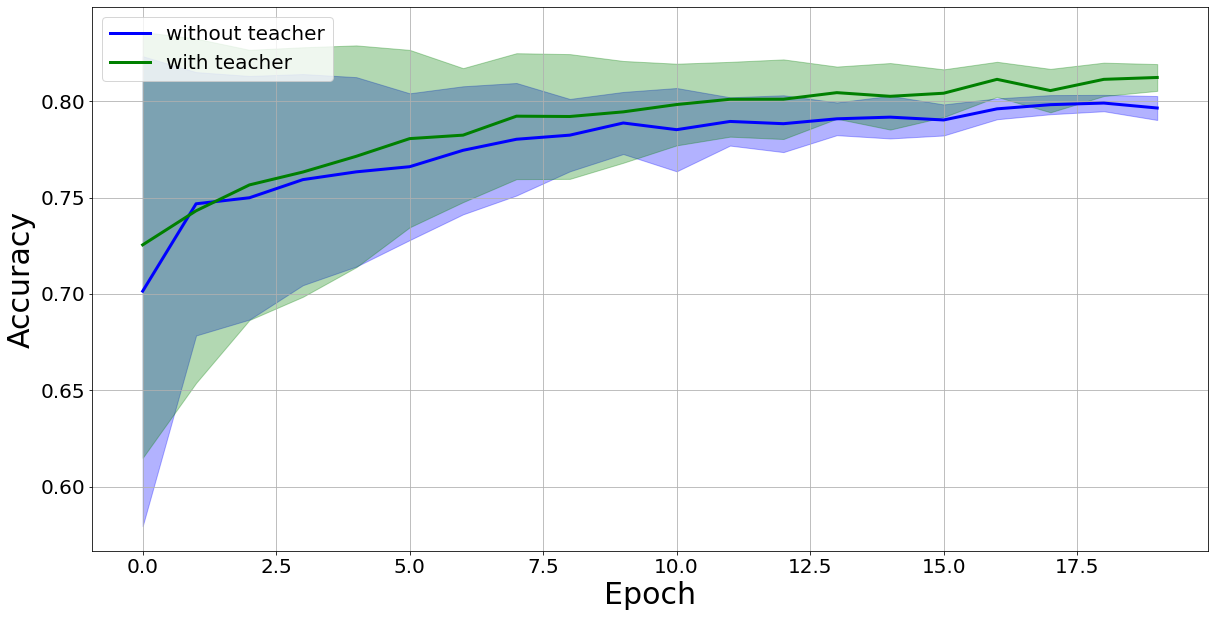

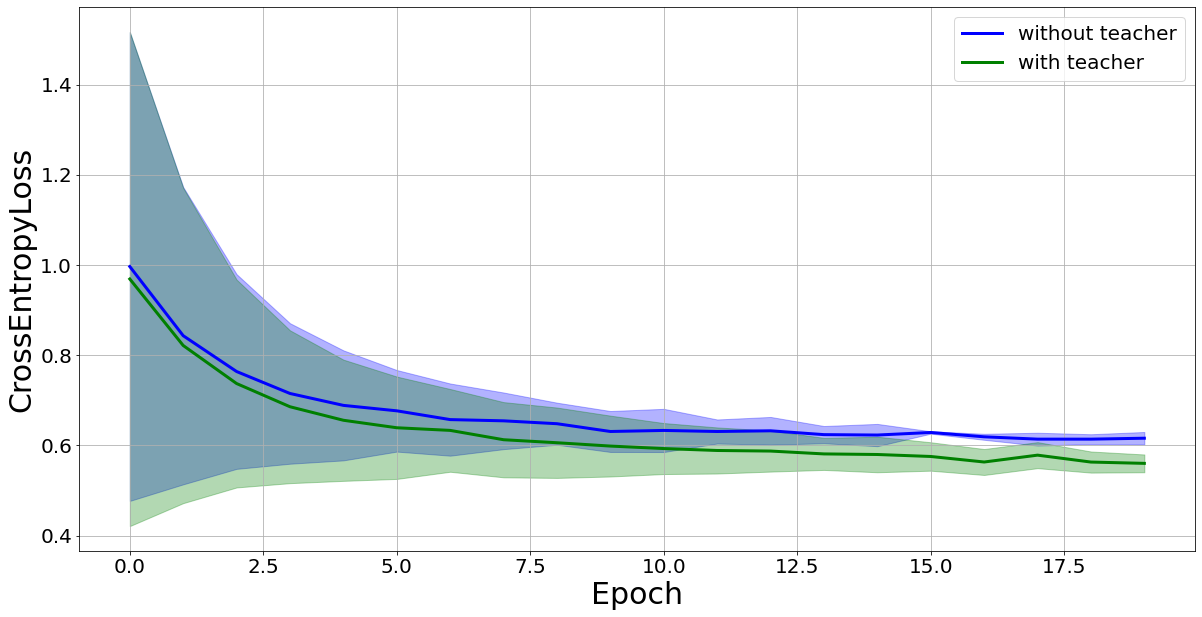

In [ ]:
for test_metric, test_metric_dist, label in zip([list_of_test_acc, list_of_test_losses],\
                                            [list_of_test_acc_dist, list_of_test_losses_dist],\
                                            ['Accuracy', 'CrossEntropyLoss']):
    mean = np.array(test_metric).mean(0)
    std = np.array(test_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='blue', label='without teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='blue')
    
    mean = np.array(test_metric_dist).mean(0)
    std = np.array(test_metric_dist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='green', label='with teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='green')
    
    plt.xlabel('Epoch', fontsize=30)
    plt.ylabel(label, fontsize=30)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

In [ ]:
print('Accuracy of student without teacher={}'.format(round(np.array(list_of_test_acc).mean(0)[-1], 3)))
print('Loss of student without teacher={}'.format(round(np.array(list_of_test_losses).mean(0)[-1], 3)))
print('Accuracy of student with teacher={}'.format(round(np.array(list_of_test_acc_dist).mean(0)[-1],3)))
print('Loss of student with teacher={}'.format(round(np.array(list_of_test_losses_dist).mean(0)[-1],3)))

Accuracy of student without teacher=0.796
Loss of student without teacher=0.616
Accuracy of student with teacher=0.812
Loss of student with teacher=0.56


# VAE model

In [ ]:
def train_epoch(train_generator, model, loss_function, optimizer, callback = None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [ ]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback = None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

In [ ]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    loss = model.loss(x_batch.view([-1,784]).to(model.device), y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [ ]:
class VAE(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device

    def __init__(self, latent_dim, input_dim, hidden_dim=200):
        """
        Standart model of VAE with ELBO optimization.
        Args:
            latent_dim: int - the dimension of latent space.
            input_dim: int - the dimension of input space.
            hidden_dim: int - the size of hidden_dim neural layer.
        Returns:
            None
        Example:
            >>> model = VAE(2, 10)
        """
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.proposal_z = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, hidden_dim),
            torch.nn.LeakyReLU(),
        )
        self.proposal_mu = torch.nn.Linear(hidden_dim, self.latent_dim)
        self.proposal_sigma = torch.nn.Linear(hidden_dim, self.latent_dim)

        self.generative_network_mnist = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, self.input_dim),
            torch.nn.Sigmoid()
        )

        self.generative_network_fmnist = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, hidden_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(hidden_dim, self.input_dim),
            torch.nn.Sigmoid()
        )

    def q_z(self, x):
        """
        Generates distribution of z provided x.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
            mu: Tensor - the matrix of shape batch_size x latent_dim.
            sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Example:
            >>>
        """
        x = x.to(self.device)

        proposal = self.proposal_z(x)
        mu = self.proposal_mu(proposal)
        sigma = torch.nn.Softplus()(self.proposal_sigma(proposal))
        return mu, sigma

    def p_z(self, num_samples):
        """
        Generetes prior distribution of z.
        Args:
            num_samples: int - the number of samples.
        Returns:
            tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape num_samples x latent_dim.
            	sigma: Tensor - the matrix of shape num_samples x latent_dim.
        Example:
            >>>
        """
        mu = torch.zeros([num_samples, self.latent_dim], device=self.device)
        sigma = torch.ones([num_samples, self.latent_dim], device=self.device)
        return mu, sigma

    def sample_z(self, distr, num_samples=1):
        """
        Generates samples from normal distribution q(z|x).
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            num_samples: int - the number of samples for each element.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x latent_dim - samples from normal distribution in latent space.
        Example:
            >>>
        """
        mu, sigma = distr
        mu = mu.to(self.device)
        sigma = sigma.to(self.device)

        batch_size = mu.shape[0]

        bias = mu.view([batch_size, 1, self.latent_dim])

        epsilon = torch.randn([batch_size, num_samples, self.latent_dim],
                              requires_grad=True,
                              device=self.device)
        scale = sigma.view([batch_size, 1, self.latent_dim])

        return bias + epsilon * scale

    def q_x_mnist(self, z):
        """
        Given the latent representation matrix z, returns the matrix of Bernoulli distribution parameters for sampling x objects.
        Args:
            z: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples from latent space.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters.
        Example:
            >>>
        """
        z = z.to(self.device)
        out = self.generative_network_mnist(z)

        return torch.clamp(out, 0.01, 0.99)

    def q_x_fmnist(self, z):
        """
        Given the latent representation matrix z, returns the matrix of Bernoulli distribution parameters for sampling x objects.
        Args:
            z: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples from latent space.
        Returns:
            Tensor - the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters.
        Example:
            >>>
        """
        z = z.to(self.device)
        out = self.generative_network_fmnist(z)

        return torch.clamp(out, 0.01, 0.99)

    def loss(self, batch_x, batch_y):
        """
        Calculate ELBO approximation of log likelihood for given batch with negative sign.
        Args:
            batch_x: FloatTensor - the matrix of shape batch_size x input_dim.
            batch_y: FloatTensor - dont uses parameter in this model.
        Returns:
            Tensor - scalar, ELBO approximation of log likelihood for given batch with negative sign.
        Example:
            >>>
        """
        batch_x = batch_x.to(self.device)
        batch_y = batch_y.to(self.device)

        batch_size = batch_x.shape[0]

        propos_distr = self.q_z(batch_x)
        pri_distr = self.p_z(batch_size)

        x_distr_mnist = self.q_x_mnist(self.sample_z(propos_distr))
        x_distr_fmnist = self.q_x_fmnist(self.sample_z(propos_distr))

        expectation_mnist = torch.mean(
            self.log_mean_exp(
                self.log_likelihood(
                    batch_y, x_distr_mnist)), dim=0)
        
        expectation_fmnist = torch.mean(
            self.log_mean_exp(
                self.log_likelihood(
                    batch_x, x_distr_fmnist)), dim=0)     

        divergence = self.divergence_KL_normal(propos_distr, pri_distr)

        return -1 * (torch.mean(expectation_mnist - divergence, dim=0) + torch.mean(expectation_fmnist - divergence, dim=0))

    def generate_samples(self, num_samples):
        """
        Generate samples of object x from noises in latent space.
        Args:
            num_samples: int - the number of samples, witch need to generate.
        Returns:
            Tensor - the matrix of shape num_samples x input_dim.
        Example:
            >>>
        """
        distr_z = self.p_z(num_samples=1)

        z = self.sample_z(distr, num_samples=num_samples)

        distr_x = self.q_x(z).view([num_samples, -1])

        return torch.bernoulli(distr_x, device=self.device)

    @staticmethod
    def log_pdf_normal(distr, samples):
        """
        The function calculates the logarithm of the probability density at a point relative to the corresponding normal distribution given componentwise by its mean and standard deviation.
        Args:
            distr = (mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            samples: Tensor - the tensor of shape batch_size x num_samples x latent_dim, samples in latent space.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples, each element of which is the logarithm of the probability density of a point relative to the corresponding distribution.
        Example:
            >>>
        """
        mu, sigma = distr

        batch_size = mu.shape[0]
        latent_dim = mu.shape[1]

        f1 = torch.sum(((samples -
                         mu.view([batch_size, 1, latent_dim]))**2) /
                       sigma.view([batch_size, 1, latent_dim])**2, dim=2)
        f2 = mu.shape[1] * (math.log(2) + math.log(math.pi))
        f3 = torch.sum(torch.log(sigma), dim=1).view(batch_size, 1)
        return -0.5 * (f1 + f2) - f3

    @staticmethod
    def log_likelihood(x_true, x_distr):
        """
        Calculate log likelihood between x_true and x_distr.
        Args:
            x_true:  Tensor - the matrix of shape batch_size x input_dim.
            x_distr: Tensor - the tensor of shape batch_size x num_samples x input_dim, Bernoulli distribution parameters.
        Returns:
            Tensor - the matrix of shape batch_size x num_samples - log likelihood for each sample.
        Example:
            >>>
        """
        batch_size = x_distr.shape[0]
        input_dim = x_distr.shape[2]

        bernoulli_log_likelihood = torch.log(
            x_distr) * x_true.view([batch_size, 1, input_dim])
        bernoulli_log_likelihood += torch.log(1 - x_distr) * (
            1 - x_true).view([batch_size, 1, input_dim])

        return torch.sum(bernoulli_log_likelihood, dim=2)

    @staticmethod
    def log_mean_exp(data):
        """
        Args:
            data: Tensor - the tensor of shape n_1 x n_2 x ... x n_K.
        Returns:
            Tensor - the tensor of shape n_1 x n_2 x ,,, x n_{K - 1}.
        Example:
            >>>
        """

        return torch.logsumexp(data, dim=-1) - \
            torch.log(torch.Tensor([data.shape[-1]]).to(data.device))

    @staticmethod
    def divergence_KL_normal(q_distr, p_distr):
        """
        Calculate KL-divergence KL(q||p) between n-pairs of normal distribution.
        Args:
            q_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
            p_distr=(mu, sigma): tuple(Tensor, Tensor) - the normal distribution parameters.
                mu: Tensor - the matrix of shape batch_size x latent_dim.
                sigma: Tensor - the matrix of shape batch_size x latent_dim.
        Returns:
            Tensor - the vector of shape n, each value of which is a KL-divergence between pair of normal distribution.
        Example:
            >>>
        """
        q_mu, q_sigma = q_distr
        p_mu, p_sigma = p_distr

        D_KL = torch.sum((q_sigma / p_sigma)**2, dim=1)
        D_KL -= p_mu.shape[1]
        D_KL += 2 * torch.sum(torch.log(p_sigma), dim=1) - \
            2 * torch.sum(torch.log(q_sigma), dim=1)
        D_KL += torch.sum((p_mu - q_mu) * (p_mu - q_mu) / (p_sigma**2), dim=1)
        return 0.5 * D_KL

    def forward(self, x):
      """
        Generate decoded sample after encoding.
        Args:
            x: Tensor - the matrix of shape batch_size x input_dim.
        Returns:
            Tensor - the matrix of shape batch_size x input_dim.
        Example:
            >>>
        """
      return self.q_x(self.sample_z(self.q_z(x))).view_as(x)

In [ ]:
optimizer = torch.optim.Adam
loss_function = torch.nn.MSELoss()
d = 64

# Отрисовка изменения

In [ ]:
Autoencoder = VAE(2, 28*28)
Autoencoder.to(device)

trainer(count_of_epoch=20, 
        batch_size=64, 
        dataset=FashionDigit,
        model=Autoencoder, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001)

In [ ]:
def draw_samples_grid_vae(model,
                          dataset,
                          num_row=15,
                          num_colum=15,
                          images_size=(28, 28)):
    """
    Illustrate how change digits x where change point in latent space z.
    Args:
        model: nn.Module - model VAE or IWAE.
        num_row: int - the number of row.
        num_colum: int - the number of column.
        images_size = (x_size, y_size): tuple(int, int) - a size of input image.
    Returns:
        figure: float - the picture
    Example:
        >>>
    """
    grid_x = norm.ppf(np.linspace(0.05, 0.95, num_colum))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, num_row))

    figure = np.zeros((images_size[0] * num_colum, images_size[1] * num_row))
    for i, y_i in enumerate(grid_x):
        for j, x_i in enumerate(grid_y):
            z_sample = np.array([[x_i, y_i]])

            if (dataset == 'fashion'):
                x_sample = model.q_x_fmnist(torch.from_numpy(z_sample).float()).view(
                    images_size).cpu().data.numpy()
                    
            if (dataset == 'digits'):
                x_sample = model.q_x_mnist(torch.from_numpy(z_sample).float()).view(
                    images_size).cpu().data.numpy()

            image = x_sample
            figure[i * images_size[0]: (i + 1) * images_size[0],
                   j * images_size[1]: (j + 1) * images_size[1]] = image

    return figure

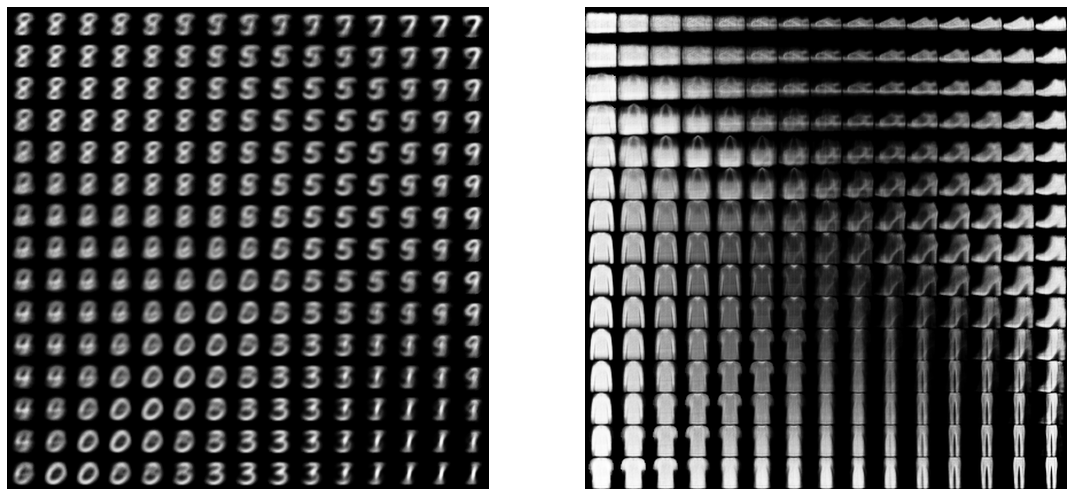

In [ ]:
figure = [draw_samples_grid_vae(Autoencoder, dataset='digits'),
          draw_samples_grid_vae(Autoencoder, dataset='fashion')]

fig, gs = plt.figure(figsize=(19,10)), gridspec.GridSpec(1, 2)
ax = []

for i in range(2):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(figure[i], cmap='Greys_r', interpolation='lanczos')
    ax[i].axis('off')
  
plt.show()

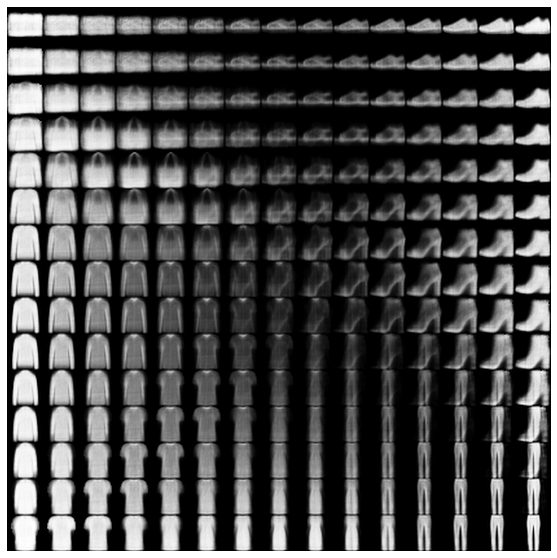

In [ ]:
figure = draw_samples_grid_vae(Autoencoder, dataset='fashion')

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', interpolation='lanczos')
plt.axis('off')
plt.show()

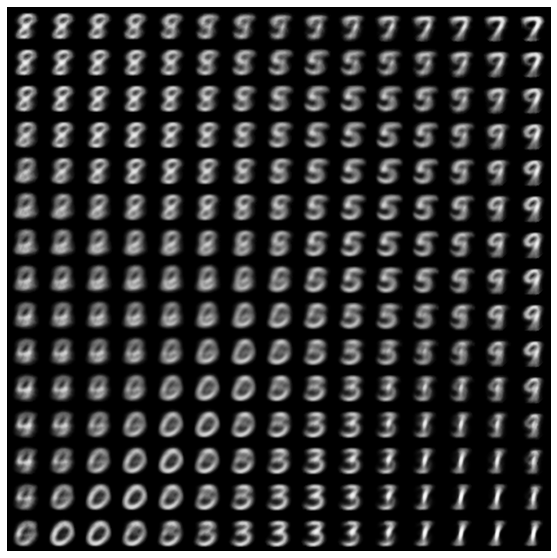

In [ ]:
figure = draw_samples_grid_vae(Autoencoder, dataset='digits')

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', interpolation='lanczos')
plt.axis('off')
plt.show()

# $\varphi$=VAE

In [ ]:
Autoencoder = VAE(64, 28*28)
Autoencoder.to(device)

trainer(count_of_epoch=75, 
        batch_size=64, 
        dataset=FashionDigit,
        model=Autoencoder, 
        loss_function=None,
        optimizer = optimizer,
        lr = 0.001)

In [ ]:
def fmnist_to_mnist(image):
    return Autoencoder.q_x_mnist(Autoencoder.sample_z(Autoencoder.q_z(image.view([-1,784])))).view([-1,784])

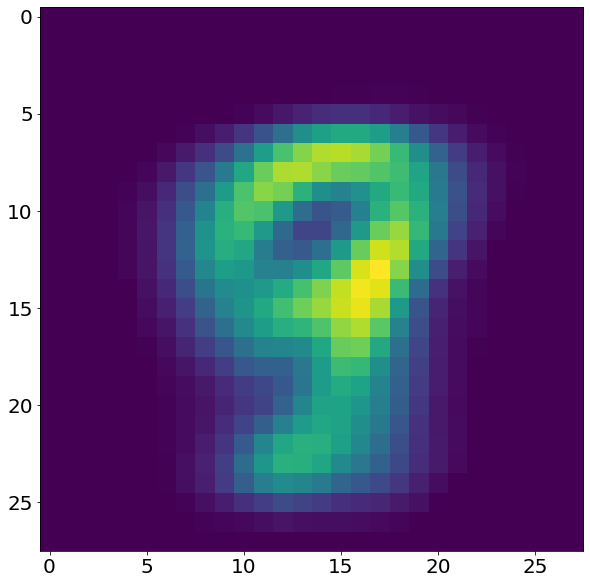

In [ ]:
plt.imshow(fmnist_to_mnist(FMNIST_train[0][0]).view([28,28]).detach().cpu().numpy())

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = Perceptron(num_layers=4).to(device)

_ = Teacher.train()
train_teacher(MNIST_train, MNIST_test)

_ = Student.train()
list_of_train_acc_mnist, list_of_test_acc_mnist, list_of_train_losses_mnist, list_of_test_losses_mnist =\
distillation_train(train_small, FMNIST_test, teacher=Teacher, phi=lambda x: fmnist_to_mnist(x))

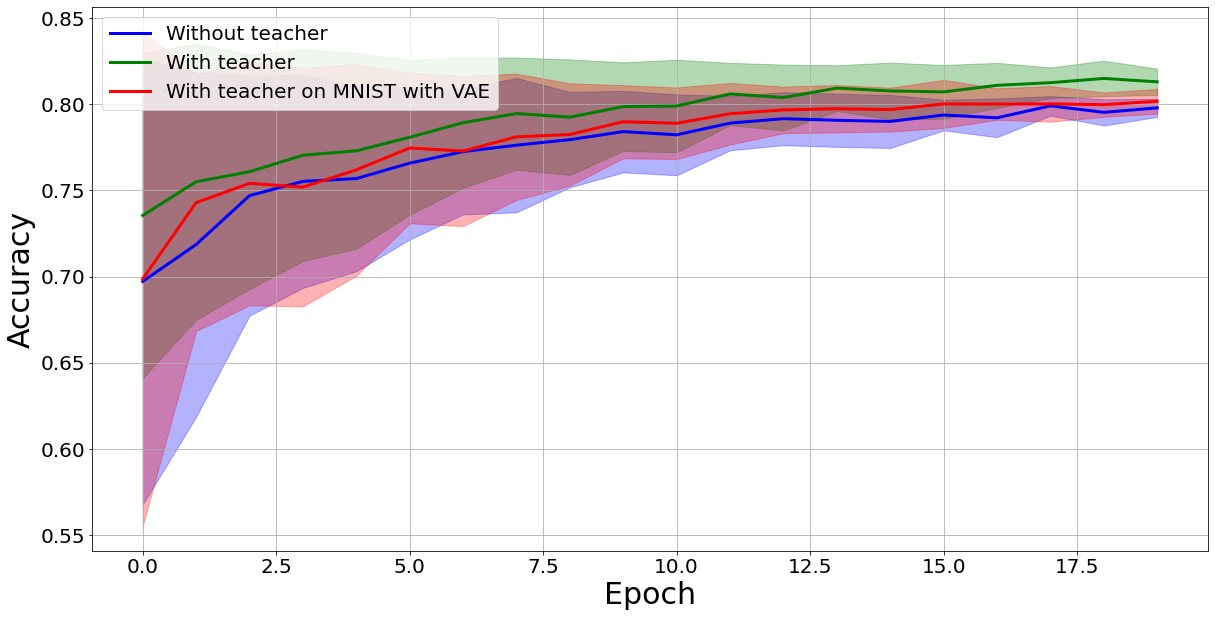

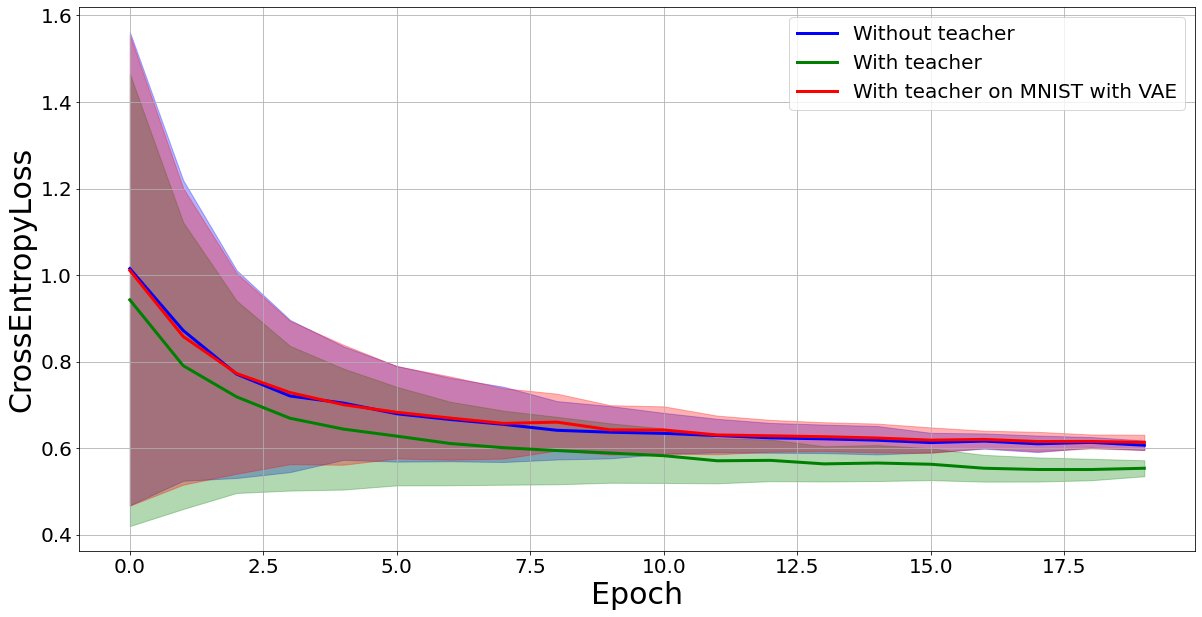

In [ ]:
for test_metric, test_metric_dist, test_metric_mnist, label in zip([list_of_test_acc, list_of_test_losses],
                                                [list_of_test_acc_dist, list_of_test_losses_dist],
                                                [list_of_test_acc_mnist, list_of_test_losses_mnist],
                                                ['Accuracy', 'CrossEntropyLoss']):
    mean = np.array(test_metric).mean(0)
    std = np.array(test_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='blue', label='Without teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='blue')
    
    mean = np.array(test_metric_dist).mean(0)
    std = np.array(test_metric_dist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='green', label='With teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='green')
    
    mean = np.array(test_metric_mnist).mean(0)
    std = np.array(test_metric_mnist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='red', label='With teacher on MNIST with VAE')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='red')
    
    plt.xlabel('Epoch', fontsize=30)
    plt.ylabel(label, fontsize=30)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = Perceptron(num_layers=4).to(device)

_ = Teacher.train()
train_teacher(MNIST_train, MNIST_test)

_ = Student.train()
list_of_train_acc_mnist_wo_vae, list_of_test_acc_mnist_wo_vae, list_of_train_losses_mnist_wo_vae, list_of_test_losses_mnist_wo_vae =\
distillation_train(train_small, FMNIST_test, teacher=Teacher)

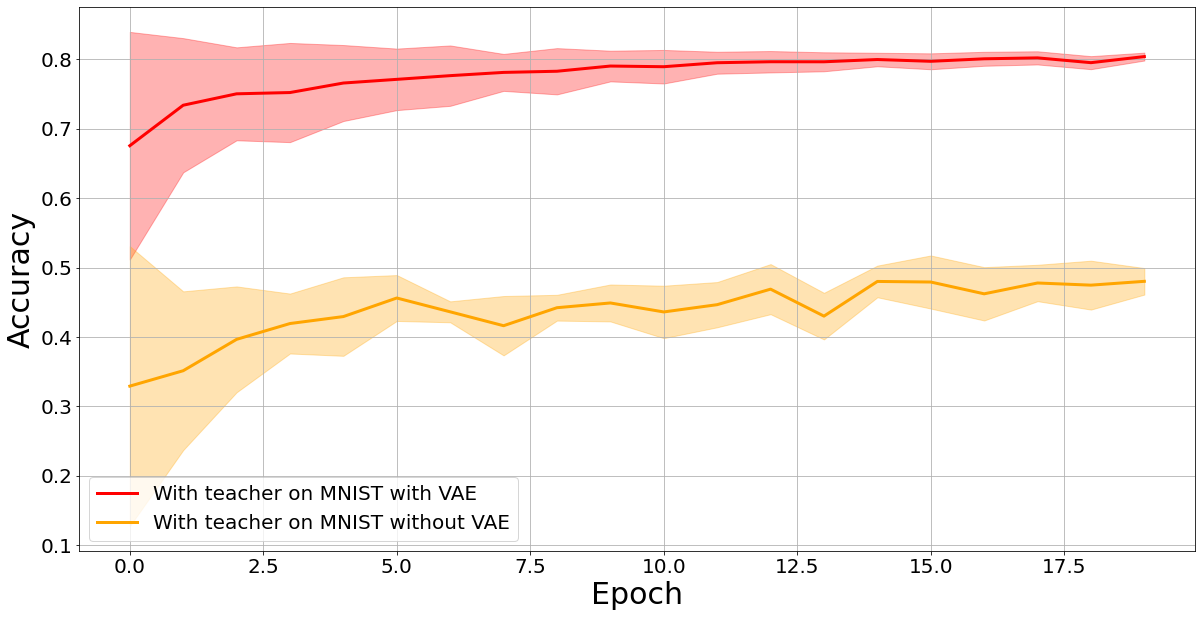

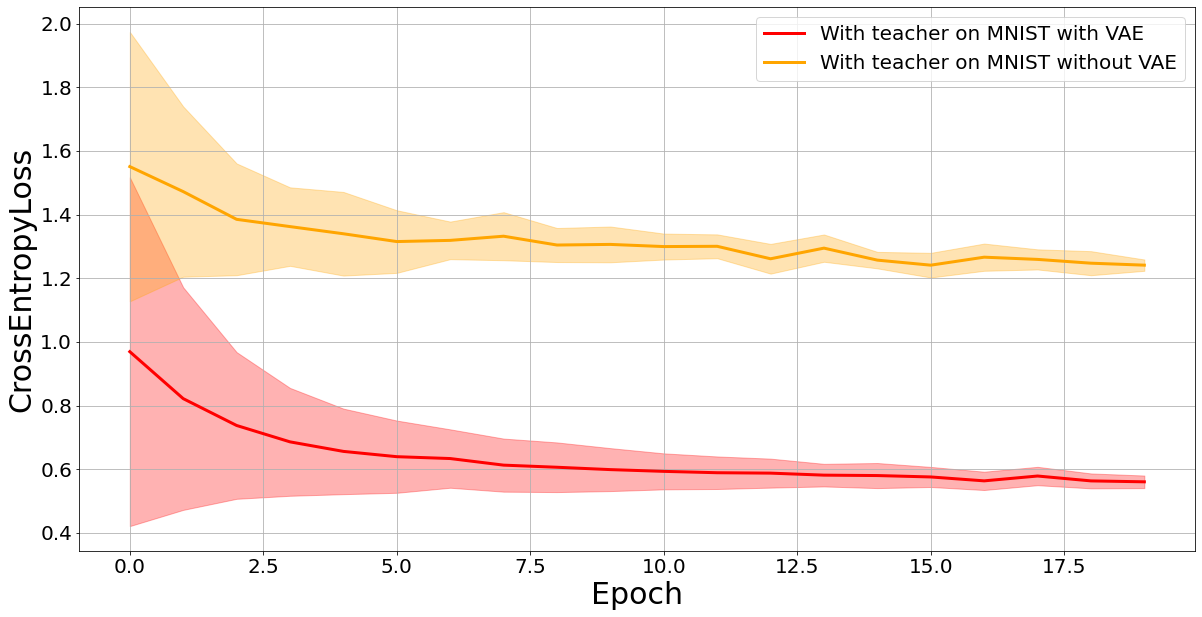

In [ ]:
for test_metric_mnist, test_metric_mnist_novae, label in zip(
                                                [list_of_test_acc_mnist, list_of_test_losses_dist],
                                                [list_of_test_acc_mnist_wo_vae, list_of_test_losses_mnist_wo_vae],
                                                ['Accuracy', 'CrossEntropyLoss']):
    mean = np.array(test_metric_mnist).mean(0)
    std = np.array(test_metric_mnist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='red', label='With teacher on MNIST with VAE')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='red')
    
    mean = np.array(test_metric_mnist_novae).mean(0)
    std = np.array(test_metric_mnist_novae).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='orange', label='With teacher on MNIST without VAE')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='orange')
    
    plt.xlabel('Epoch', fontsize=30)
    plt.ylabel(label, fontsize=30)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

In [ ]:
print('Accuracy of student with teacher on MNIST with VAE={}'.format(round(np.array(list_of_test_acc_mnist).mean(0)[-1],3)))
print('Loss of student with teacher on MNIST with VAE={}'.format(round(np.array(list_of_test_losses_mnist).mean(0)[-1],3)))
print('Accuracy of student with teacher on MNIST w/o VAE={}'.format(round(np.array(list_of_test_acc_mnist_wo_vae).mean(0)[-1],3)))
print('Loss of student with teacher on MNIST w/o VAE={}'.format(round(np.array(list_of_test_losses_mnist_wo_vae).mean(0)[-1],3)))

Accuracy of student with teacher on MNIST with VAE=0.804
Loss of student with teacher on MNIST with VAE=0.625
Accuracy of student with teacher on MNIST w/o VAE=0.48
Loss of student with teacher on MNIST w/o VAE=1.241


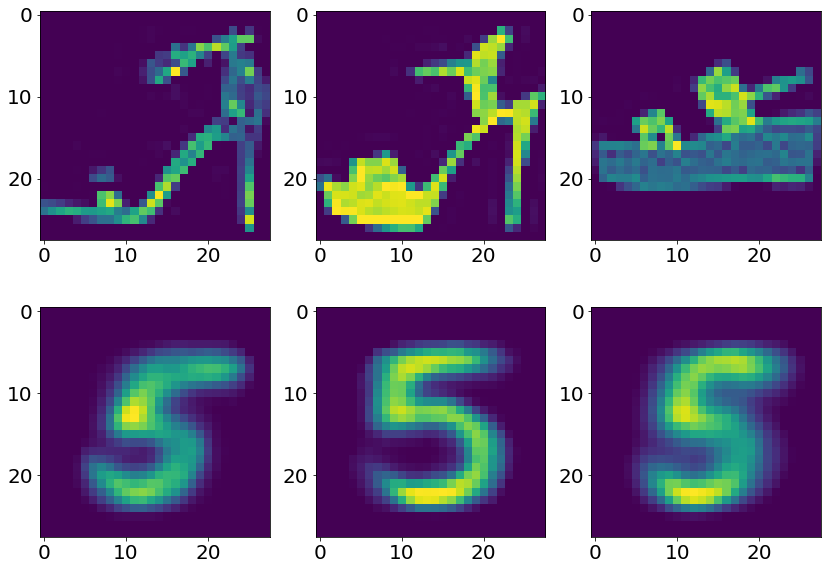

In [ ]:
indices = [8,9,12]

fmnist_images = []
for i in indices:
    fmnist_images.append(FMNIST_train[i][0])

mnist_images = []
for im in fmnist_images:
    a = im.view([1,784])
    b = fmnist_to_mnist(a).view([28,28])
    mnist_images.append(b.cpu().detach().numpy())    

fig, gs = plt.figure(figsize=(14,10)), gridspec.GridSpec(2, 3)

ax = []

for i in range(3):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(fmnist_images[i].view([28,28])))

for i in range(3):
    ax.append(fig.add_subplot(gs[i+3]))
    ax[i+3].imshow(np.array(mnist_images[i]))

plt.show()

# Синтетическая расширенная выборка

In [ ]:
X = []
Y = []
for x, y in train_small:
    im = fmnist_to_mnist(x).view([1,28,28])
    for i in range(70):
        X.append(im)
        Y.append(y)

X_train = torch.stack([torch.from_numpy(np.array(i.cpu().detach())) for i in X])
y_train = torch.stack([torch.from_numpy(np.array(i)) for i in Y])
X_train = X_train.reshape((-1, 1, 28, 28)).float()
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)

GMNIST_train, GMNIST_test = torch.utils.data.random_split(train_dataset,
                                                          [60000, 10000],
                                                          generator=torch.Generator().manual_seed(42))

In [ ]:
Student = Perceptron(num_layers=1).to(device)
Teacher = Perceptron(num_layers=4).to(device)

_ = Teacher.train()
train_teacher(GMNIST_train, GMNIST_test)

_ = Student.train()
list_of_train_acc_ext_mnist, list_of_test_acc_ext_mnist, list_of_train_losses_ext_mnist, list_of_test_losses_ext_mnist =\
distillation_train(train_small, FMNIST_test, teacher=Teacher, phi=lambda x: fmnist_to_mnist(x))

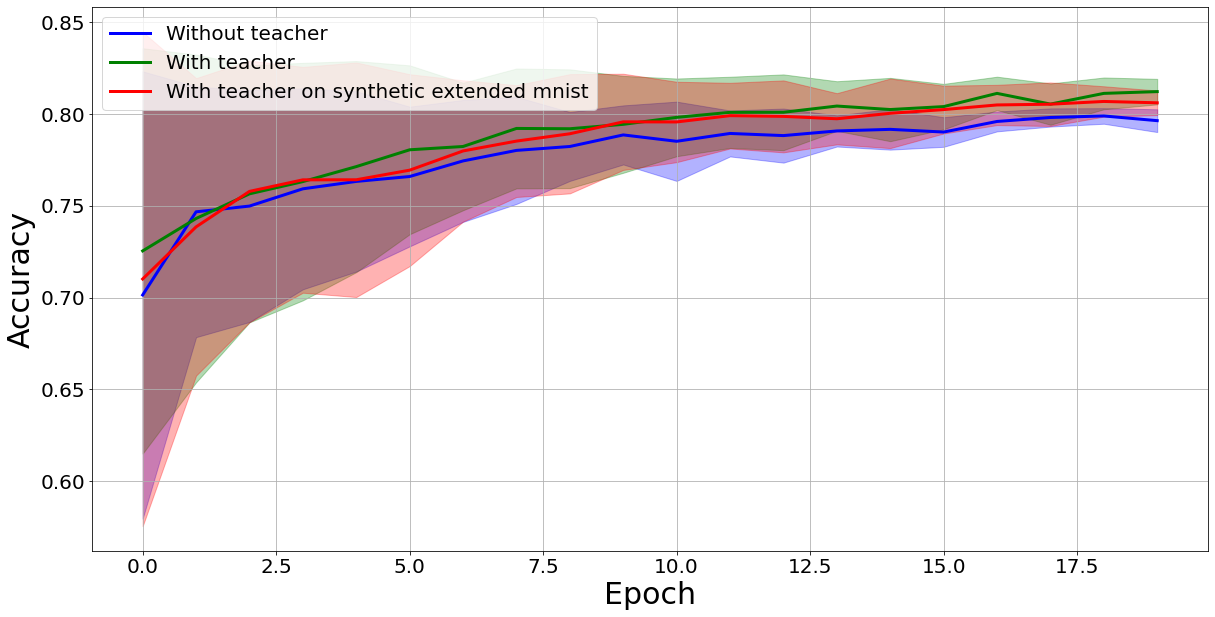

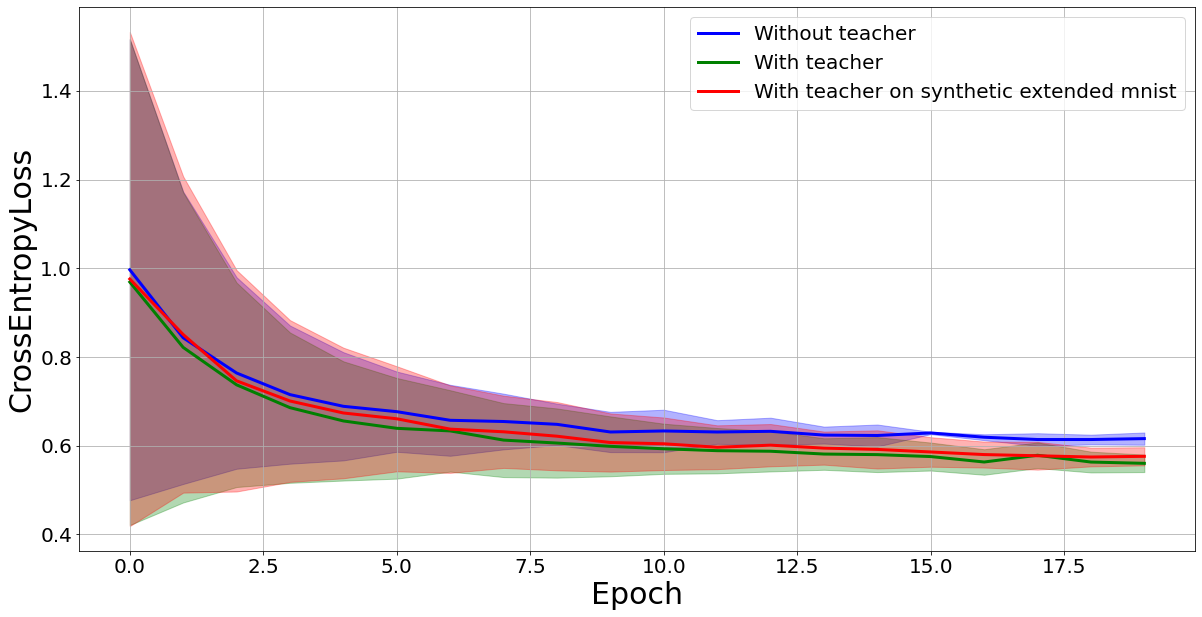

In [ ]:
for test_metric, test_metric_dist, test_metric_ext_mnist, label in zip([list_of_test_acc, list_of_test_losses],
                                                [list_of_test_acc_dist, list_of_test_losses_dist],
                                                [list_of_test_acc_ext_mnist, list_of_test_losses_ext_mnist],
                                                ['Accuracy', 'CrossEntropyLoss']):
    mean = np.array(test_metric).mean(0)
    std = np.array(test_metric).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='blue', label='Without teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='blue')
    
    mean = np.array(test_metric_dist).mean(0)
    std = np.array(test_metric_dist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='green', label='With teacher')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='green')
    
    mean = np.array(test_metric_ext_mnist).mean(0)
    std = np.array(test_metric_ext_mnist).std(0)
    x_axis = np.arange(0, len(mean))
    
    plt.plot(x_axis, mean, color='red', label='With teacher on synthetic extended mnist')
    plt.fill_between(x_axis, mean-std, mean+std, alpha=0.3, color='red')
    
    plt.xlabel('Epoch', fontsize=30)
    plt.ylabel(label, fontsize=30)
    plt.grid()
    plt.legend(loc='best')
    plt.show()

In [ ]:
print('Accuracy of student with teacher on synthetic extended MNIST={}'.format(round(np.array(list_of_test_acc_ext_mnist).mean(0)[-1],3)))
print('Loss of student with teacher on synthetic extended={}'.format(round(np.array(list_of_test_losses_ext_mnist).mean(0)[-1],3)))

Accuracy of student with teacher on synthetic extended MNIST=0.806
Loss of student with teacher on synthetic extended=0.576
